### Construct training data

In [2]:
import pandas as pd
import geopandas as gpd
from sklearn.preprocessing import OneHotEncoder

from fwi_predict.constants import WQ_RANGES
from fwi_predict.wq import get_in_range

In [3]:
measurements = gpd.read_file("../data/clean/measurements_with_metadata.geojson")
gfs = pd.read_csv("../data/clean/gfs_forecasts.csv")

In [4]:
predict_df = measurements.set_index('measurement_idx').join(gfs)

In [10]:
predict_df['month'] = predict_df['sample_dt'].dt.month
predict_df['morning'] = predict_df['time_of_day'] == 'morning' # Bad since we found potential error and could have NAs, but rough for now

In [71]:
for param in WQ_RANGES.keys():
    range_name = param.split('_')[0] + '_in_range'
    predict_df[range_name] = get_in_range(param, predict_df[param], predict_df['time_of_day'])

In [75]:
y_vars_regress = ['do_mg_per_L', 'ph', 'ammonia_mg_per_L', 'turbidity_cm']
y_vars_class = ['do_in_range', 'ph_in_range', 'ammonia_in_range', 'turbidity_in_range']
X_vars = ['morning', 'property_area_acres', 'pond_depth_meters'] + gfs.columns.tolist()
group = ['farm_id']

In [ ]:
predict_df = predict_df[y_vars_regress + y_vars_class + X_vars + group]

coltype_designator = {col: 'y_regress' for col in y_vars_regress}
coltype_designator.update({col: 'y_class' for col in y_vars_class})
coltype_designator.update({col: 'X' for col in X_vars})
coltype_designator.update({col: 'group' for col in group})

predict_df.columns = pd.MultiIndex.from_tuples([(coltype_designator[col], col) for col in predict_df.columns])
predict_df.columns.names = ['var_type', 'var_name']

In [77]:
predict_df.to_csv("../data/clean/predict_df.csv")

In [57]:
from ydata_profiling import ProfileReport

### Data exploration

In [78]:
report = ProfileReport(predict_df, title='Prediction Dataframe')

  0%|          | 0/14638 [00:00<?, ?it/s]

c:\Users\squaade\Documents\Github\fwi-predict\.venv\lib\site-packages\dataprep\eda\distribution\render.py:274: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({col: [nrows - npresent]}, index=["Others"]))
c:\Users\squaade\Documents\Github\fwi-predict\.venv\lib\site-packages\dataprep\eda\distribution\render.py:274: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({col: [nrows - npresent]}, index=["Others"]))


In [11]:
# report

C:\Users\squaade\AppData\Local\Temp\ipykernel_39716\2493412230.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = predict_df.corr().loc['y', 'X'].drop(columns='measurement_idx').T


Text(0.5, 1.0, 'Outcome/feature correlations')

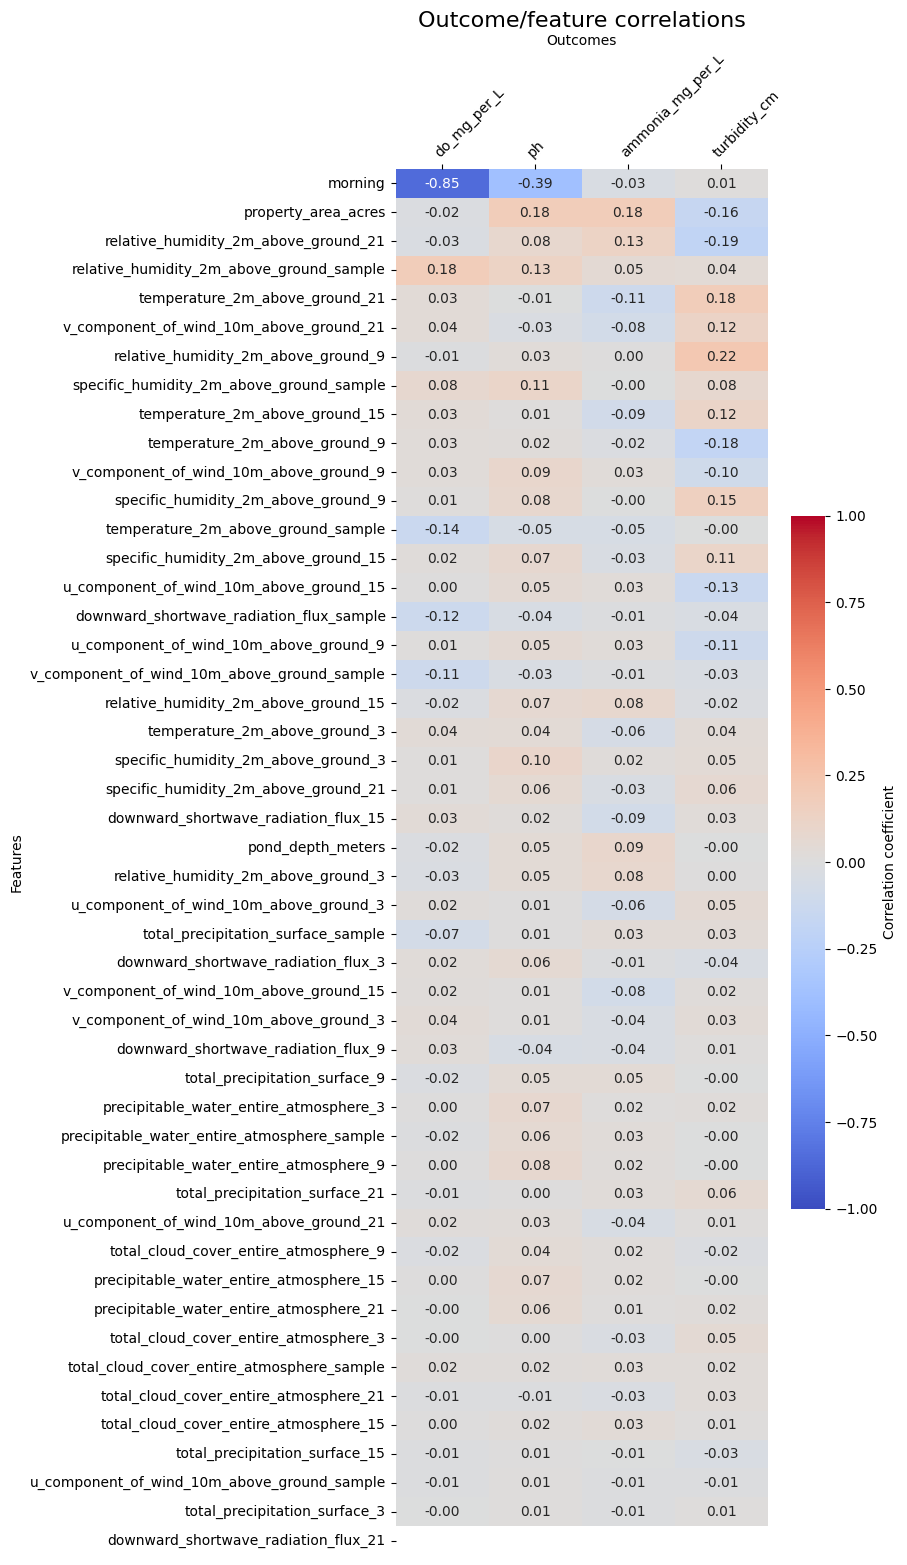

In [60]:
# Generate heatmap of correlations between y vars (as columns) and X vars (as rows)
import seaborn as sns
import matplotlib.pyplot as plt

corr = predict_df.corr().loc['y', 'X'].drop(columns='measurement_idx').T
corr = corr.loc[corr.apply(lambda x: sum(abs(x)), axis=1).sort_values(ascending=False).index]

fig, ax = plt.subplots(figsize=(6, 18))
sns.heatmap(corr,
            ax=ax,
            cmap='coolwarm',
            center=0,
            annot=True,
            fmt=".2f",
            vmin=-1,
            vmax=1, # Align colorbar with top of plot
            cbar_kws={'shrink':0.7, 'label': 'Correlation coefficient'}) 

# Make the y var labels on the top
ax.xaxis.tick_top() # Rotate them 45 degrees
ax.xaxis.set_label_position('top')
plt.xticks(rotation=45, rotation_mode='anchor', ha='left')
ax.set_xlabel("Outcomes")
ax.set_ylabel("Features")
ax.set_title("Outcome/feature correlations", fontsize=16)